In [1]:

import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
from pathlib import Path

In [2]:
tnia_images_path = Path(r"D:\images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2024_04_09_SAM_training')

large_images = tifffile.imread(parent_path / 'training.tif')
large_masks = tifffile.imread(parent_path / 'training_groundtruth.tif')

In [3]:

large_images.shape

(165, 768, 1024)

In [4]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [5]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [6]:
images.shape, masks.shape

((1980, 256, 256), (1980, 256, 256))

In [7]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (1642, 256, 256)
Mask shape: (1642, 256, 256)


In [8]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)
     

c:\Users\bnort\miniconda3\envs\pytorch_and_SAM2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1642
})

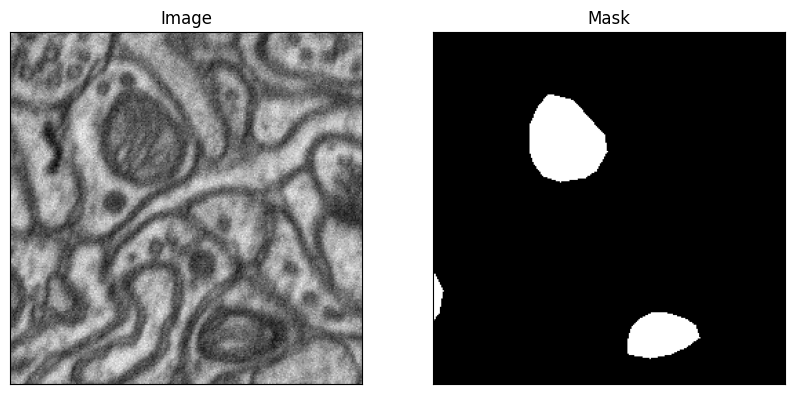

In [10]:

img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [11]:

#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [12]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]

    # add fake channels
    image = np.stack([image, image, image], axis=-1)
    
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [13]:

# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [14]:


# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [15]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [16]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [17]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [18]:

batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [19]:

# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [20]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [32]:

from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 821/821 [05:54<00:00,  2.32it/s]


EPOCH: 0
Mean loss: 0.20233543437251075


100%|██████████| 821/821 [06:58<00:00,  1.96it/s]

EPOCH: 1
Mean loss: 0.13346155787320144


In [33]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

# Save the model's state dictionary to a file
torch.save(model.state_dict(), parent_path / "mito_model_checkpoint.pth")

In [34]:

from transformers import SamModel, SamConfig, SamProcessor
import torch

In [35]:

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load( parent_path / "mito_model_checkpoint.pth"))

<All keys matched successfully>

In [76]:
help(my_mito_model)

Help on SamModel in module transformers.models.sam.modeling_sam object:

class SamModel(SamPreTrainedModel)
 |  SamModel(config)
 |  
 |  Segment Anything Model (SAM) for generating segmentation masks, given an input image and  optional 2D location and bounding boxes.
 |  This model inherits from [`PreTrainedModel`]. Check the superclass documentation for the generic methods the
 |  library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads
 |  etc.)
 |  
 |  This model is also a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass.
 |  Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage
 |  and behavior.
 |  
 |  Parameters:
 |      config ([`SamConfig`]): Model configuration class with all the parameters of the model.
 |          Initializing with a config file does not load the weights associated with the model, only the
 |      

In [36]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

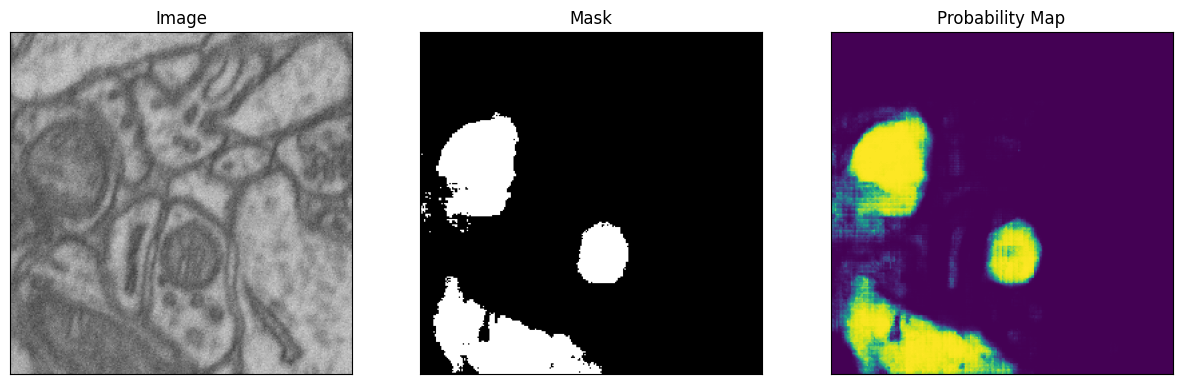

In [37]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# make 3 dummy channels
test_image = np.stack([test_image, test_image, test_image], axis=-1)

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")



# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [38]:

#Apply a trained model on large image
large_test_image = tifffile.imread( parent_path / "training-slice.tif")
#large_test_image = np.stack([large_test_image, large_test_image, large_test_image], axis=-1)

large_test_image.shape

#large_test_image = large_test_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap

In [53]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 1000

# Define the size of your grid
grid_size = 20

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [54]:
print(len(xv_list), len(xv_list[0]))

20 20


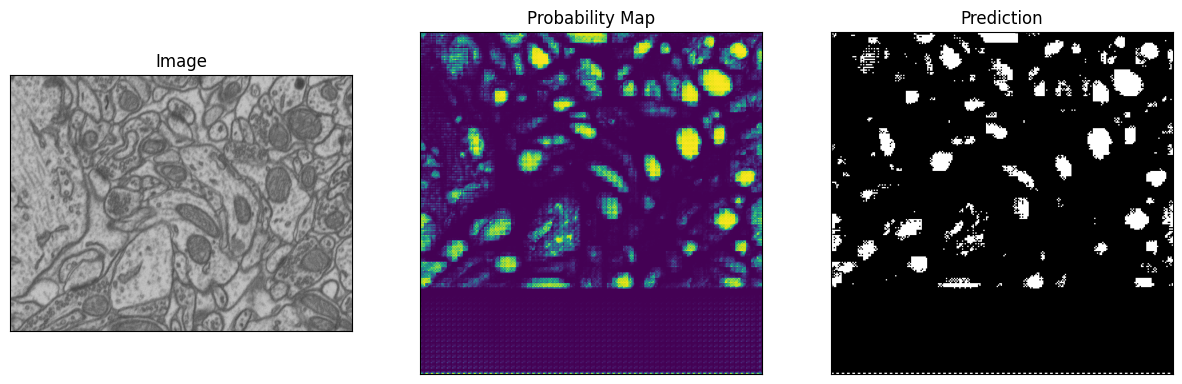

In [55]:
model_ = my_mito_model

# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
#random_array = patches[i, j]


#single_patch = Image.fromarray(random_array)
single_patch = large_test_image

single_patch = np.stack([single_patch, single_patch, single_patch], axis=-1)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
model_.eval()

# forward pass
with torch.no_grad():
  outputs = model_(**inputs, multimask_output=False)
  #outputs = model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [57]:
single_patch.shape, single_patch_prediction.shape

((768, 1024, 3), (256, 256))

In [76]:
type(input_points)

torch.Tensor

In [50]:

input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

model_ = my_mito_model

single_patch = large_test_image
single_patch = np.stack([single_patch, single_patch, single_patch], axis=-1)

probs=[]
predictions=[]

for point_list in input_points:
   for point in point_list:
      x, y = point
      print(point)
    
      _points = torch.tensor(point).view(1, 1, 1, 2)

      inputs = processor(single_patch, input_points=_points, return_tensors="pt")

      # Move the input tensor to the GPU if it's not already there
      inputs = {k: v.to(device) for k, v in inputs.items()}
      model_.eval()

      # forward pass
      with torch.no_grad():
        outputs = model_(**inputs, multimask_output=False)
        #outputs = model(**inputs, multimask_output=False)

      # apply sigmoid
      prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
      # convert soft mask to hard mask
      prob = prob.cpu().numpy().squeeze()
      prediction = (prob > 0.5).astype(np.uint8)

      probs.append(prob)
      predictions.append(prediction)

[0, 0]
[52, 0]
[105, 0]
[157, 0]
[210, 0]
[262, 0]
[315, 0]
[368, 0]
[420, 0]
[473, 0]
[525, 0]
[578, 0]
[630, 0]
[683, 0]
[736, 0]
[788, 0]
[841, 0]
[893, 0]
[946, 0]
[999, 0]
[0, 52]
[52, 52]
[105, 52]
[157, 52]
[210, 52]
[262, 52]
[315, 52]
[368, 52]
[420, 52]
[473, 52]
[525, 52]
[578, 52]
[630, 52]
[683, 52]
[736, 52]
[788, 52]
[841, 52]
[893, 52]
[946, 52]
[999, 52]
[0, 105]
[52, 105]
[105, 105]
[157, 105]
[210, 105]
[262, 105]
[315, 105]
[368, 105]
[420, 105]
[473, 105]
[525, 105]
[578, 105]
[630, 105]
[683, 105]
[736, 105]
[788, 105]
[841, 105]
[893, 105]
[946, 105]
[999, 105]
[0, 157]
[52, 157]
[105, 157]
[157, 157]
[210, 157]
[262, 157]
[315, 157]
[368, 157]
[420, 157]
[473, 157]
[525, 157]
[578, 157]
[630, 157]
[683, 157]
[736, 157]
[788, 157]
[841, 157]
[893, 157]
[946, 157]
[999, 157]
[0, 210]
[52, 210]
[105, 210]
[157, 210]
[210, 210]
[262, 210]
[315, 210]
[368, 210]
[420, 210]
[473, 210]
[525, 210]
[578, 210]
[630, 210]
[683, 210]
[736, 210]
[788, 210]
[841, 210]
[893, 21

In [43]:
len(probs), len(predictions)

(400, 400)

In [60]:
# make predictions numpy
probs = np.array(probs)
i=1

from skimage import transform

rescaled_probs = transform.resize(probs, (probs.shape[0], large_image.shape[0], large_image.shape[1]), anti_aliasing=True)    

#for i in range(probs.shape[0]):
#    probs(i,:,:)=probs(i,:,:)*(i+1)
import napari
viewer = napari.Viewer()
viewer.add_image(large_test_image)
viewer.add_image(rescaled_probs)

<Image layer 'rescaled_probs' at 0x1c73de162c0>

In [45]:
SAM_WEIGHTS_URL = {
    "default": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth",
    "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
}

def get_weights_path(model_type: str) -> Optional[Path]:
    """Returns the path to the weight of a given model architecture."""
    weight_url = SAM_WEIGHTS_URL[model_type]

    cache_dir = Path.home() / ".cache/tnia-sam"
    cache_dir.mkdir(parents=True, exist_ok=True)

    weight_path = cache_dir / weight_url.split("/")[-1]

    # Download the weights if they don't exist
    if not weight_path.exists():
        download_weights(weight_url, weight_path)

(256, 256)

In [75]:
from segment_anything.automatic_mask_generator import SamAutomaticMaskGenerator
from segment_anything import sam_model_registry, SamPredictor 
#from segment_anything import sam_model_registry, SamPredictor

# Load the model configuration
#model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
#processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


# Create an instance of the model architecture with the loaded configuration
#my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
#my_mito_model.load_state_dict(torch.load( parent_path / "mito_model_checkpoint.pth"))
#my_mito_model.load_pr
#test = SamPredictor(model)

model = sam_model_registry['vit_b'](parent_path / "mito_model_checkpoint.pth")

RuntimeError: Error(s) in loading state_dict for Sam:
	Missing key(s) in state_dict: "image_encoder.pos_embed", "image_encoder.patch_embed.proj.weight", "image_encoder.patch_embed.proj.bias", "image_encoder.blocks.0.norm1.weight", "image_encoder.blocks.0.norm1.bias", "image_encoder.blocks.0.attn.rel_pos_h", "image_encoder.blocks.0.attn.rel_pos_w", "image_encoder.blocks.0.attn.qkv.weight", "image_encoder.blocks.0.attn.qkv.bias", "image_encoder.blocks.0.attn.proj.weight", "image_encoder.blocks.0.attn.proj.bias", "image_encoder.blocks.0.norm2.weight", "image_encoder.blocks.0.norm2.bias", "image_encoder.blocks.0.mlp.lin1.weight", "image_encoder.blocks.0.mlp.lin1.bias", "image_encoder.blocks.0.mlp.lin2.weight", "image_encoder.blocks.0.mlp.lin2.bias", "image_encoder.blocks.1.norm1.weight", "image_encoder.blocks.1.norm1.bias", "image_encoder.blocks.1.attn.rel_pos_h", "image_encoder.blocks.1.attn.rel_pos_w", "image_encoder.blocks.1.attn.qkv.weight", "image_encoder.blocks.1.attn.qkv.bias", "image_encoder.blocks.1.attn.proj.weight", "image_encoder.blocks.1.attn.proj.bias", "image_encoder.blocks.1.norm2.weight", "image_encoder.blocks.1.norm2.bias", "image_encoder.blocks.1.mlp.lin1.weight", "image_encoder.blocks.1.mlp.lin1.bias", "image_encoder.blocks.1.mlp.lin2.weight", "image_encoder.blocks.1.mlp.lin2.bias", "image_encoder.blocks.2.norm1.weight", "image_encoder.blocks.2.norm1.bias", "image_encoder.blocks.2.attn.rel_pos_h", "image_encoder.blocks.2.attn.rel_pos_w", "image_encoder.blocks.2.attn.qkv.weight", "image_encoder.blocks.2.attn.qkv.bias", "image_encoder.blocks.2.attn.proj.weight", "image_encoder.blocks.2.attn.proj.bias", "image_encoder.blocks.2.norm2.weight", "image_encoder.blocks.2.norm2.bias", "image_encoder.blocks.2.mlp.lin1.weight", "image_encoder.blocks.2.mlp.lin1.bias", "image_encoder.blocks.2.mlp.lin2.weight", "image_encoder.blocks.2.mlp.lin2.bias", "image_encoder.blocks.3.norm1.weight", "image_encoder.blocks.3.norm1.bias", "image_encoder.blocks.3.attn.rel_pos_h", "image_encoder.blocks.3.attn.rel_pos_w", "image_encoder.blocks.3.attn.qkv.weight", "image_encoder.blocks.3.attn.qkv.bias", "image_encoder.blocks.3.attn.proj.weight", "image_encoder.blocks.3.attn.proj.bias", "image_encoder.blocks.3.norm2.weight", "image_encoder.blocks.3.norm2.bias", "image_encoder.blocks.3.mlp.lin1.weight", "image_encoder.blocks.3.mlp.lin1.bias", "image_encoder.blocks.3.mlp.lin2.weight", "image_encoder.blocks.3.mlp.lin2.bias", "image_encoder.blocks.4.norm1.weight", "image_encoder.blocks.4.norm1.bias", "image_encoder.blocks.4.attn.rel_pos_h", "image_encoder.blocks.4.attn.rel_pos_w", "image_encoder.blocks.4.attn.qkv.weight", "image_encoder.blocks.4.attn.qkv.bias", "image_encoder.blocks.4.attn.proj.weight", "image_encoder.blocks.4.attn.proj.bias", "image_encoder.blocks.4.norm2.weight", "image_encoder.blocks.4.norm2.bias", "image_encoder.blocks.4.mlp.lin1.weight", "image_encoder.blocks.4.mlp.lin1.bias", "image_encoder.blocks.4.mlp.lin2.weight", "image_encoder.blocks.4.mlp.lin2.bias", "image_encoder.blocks.5.norm1.weight", "image_encoder.blocks.5.norm1.bias", "image_encoder.blocks.5.attn.rel_pos_h", "image_encoder.blocks.5.attn.rel_pos_w", "image_encoder.blocks.5.attn.qkv.weight", "image_encoder.blocks.5.attn.qkv.bias", "image_encoder.blocks.5.attn.proj.weight", "image_encoder.blocks.5.attn.proj.bias", "image_encoder.blocks.5.norm2.weight", "image_encoder.blocks.5.norm2.bias", "image_encoder.blocks.5.mlp.lin1.weight", "image_encoder.blocks.5.mlp.lin1.bias", "image_encoder.blocks.5.mlp.lin2.weight", "image_encoder.blocks.5.mlp.lin2.bias", "image_encoder.blocks.6.norm1.weight", "image_encoder.blocks.6.norm1.bias", "image_encoder.blocks.6.attn.rel_pos_h", "image_encoder.blocks.6.attn.rel_pos_w", "image_encoder.blocks.6.attn.qkv.weight", "image_encoder.blocks.6.attn.qkv.bias", "image_encoder.blocks.6.attn.proj.weight", "image_encoder.blocks.6.attn.proj.bias", "image_encoder.blocks.6.norm2.weight", "image_encoder.blocks.6.norm2.bias", "image_encoder.blocks.6.mlp.lin1.weight", "image_encoder.blocks.6.mlp.lin1.bias", "image_encoder.blocks.6.mlp.lin2.weight", "image_encoder.blocks.6.mlp.lin2.bias", "image_encoder.blocks.7.norm1.weight", "image_encoder.blocks.7.norm1.bias", "image_encoder.blocks.7.attn.rel_pos_h", "image_encoder.blocks.7.attn.rel_pos_w", "image_encoder.blocks.7.attn.qkv.weight", "image_encoder.blocks.7.attn.qkv.bias", "image_encoder.blocks.7.attn.proj.weight", "image_encoder.blocks.7.attn.proj.bias", "image_encoder.blocks.7.norm2.weight", "image_encoder.blocks.7.norm2.bias", "image_encoder.blocks.7.mlp.lin1.weight", "image_encoder.blocks.7.mlp.lin1.bias", "image_encoder.blocks.7.mlp.lin2.weight", "image_encoder.blocks.7.mlp.lin2.bias", "image_encoder.blocks.8.norm1.weight", "image_encoder.blocks.8.norm1.bias", "image_encoder.blocks.8.attn.rel_pos_h", "image_encoder.blocks.8.attn.rel_pos_w", "image_encoder.blocks.8.attn.qkv.weight", "image_encoder.blocks.8.attn.qkv.bias", "image_encoder.blocks.8.attn.proj.weight", "image_encoder.blocks.8.attn.proj.bias", "image_encoder.blocks.8.norm2.weight", "image_encoder.blocks.8.norm2.bias", "image_encoder.blocks.8.mlp.lin1.weight", "image_encoder.blocks.8.mlp.lin1.bias", "image_encoder.blocks.8.mlp.lin2.weight", "image_encoder.blocks.8.mlp.lin2.bias", "image_encoder.blocks.9.norm1.weight", "image_encoder.blocks.9.norm1.bias", "image_encoder.blocks.9.attn.rel_pos_h", "image_encoder.blocks.9.attn.rel_pos_w", "image_encoder.blocks.9.attn.qkv.weight", "image_encoder.blocks.9.attn.qkv.bias", "image_encoder.blocks.9.attn.proj.weight", "image_encoder.blocks.9.attn.proj.bias", "image_encoder.blocks.9.norm2.weight", "image_encoder.blocks.9.norm2.bias", "image_encoder.blocks.9.mlp.lin1.weight", "image_encoder.blocks.9.mlp.lin1.bias", "image_encoder.blocks.9.mlp.lin2.weight", "image_encoder.blocks.9.mlp.lin2.bias", "image_encoder.blocks.10.norm1.weight", "image_encoder.blocks.10.norm1.bias", "image_encoder.blocks.10.attn.rel_pos_h", "image_encoder.blocks.10.attn.rel_pos_w", "image_encoder.blocks.10.attn.qkv.weight", "image_encoder.blocks.10.attn.qkv.bias", "image_encoder.blocks.10.attn.proj.weight", "image_encoder.blocks.10.attn.proj.bias", "image_encoder.blocks.10.norm2.weight", "image_encoder.blocks.10.norm2.bias", "image_encoder.blocks.10.mlp.lin1.weight", "image_encoder.blocks.10.mlp.lin1.bias", "image_encoder.blocks.10.mlp.lin2.weight", "image_encoder.blocks.10.mlp.lin2.bias", "image_encoder.blocks.11.norm1.weight", "image_encoder.blocks.11.norm1.bias", "image_encoder.blocks.11.attn.rel_pos_h", "image_encoder.blocks.11.attn.rel_pos_w", "image_encoder.blocks.11.attn.qkv.weight", "image_encoder.blocks.11.attn.qkv.bias", "image_encoder.blocks.11.attn.proj.weight", "image_encoder.blocks.11.attn.proj.bias", "image_encoder.blocks.11.norm2.weight", "image_encoder.blocks.11.norm2.bias", "image_encoder.blocks.11.mlp.lin1.weight", "image_encoder.blocks.11.mlp.lin1.bias", "image_encoder.blocks.11.mlp.lin2.weight", "image_encoder.blocks.11.mlp.lin2.bias", "image_encoder.neck.0.weight", "image_encoder.neck.1.weight", "image_encoder.neck.1.bias", "image_encoder.neck.2.weight", "image_encoder.neck.3.weight", "image_encoder.neck.3.bias", "prompt_encoder.pe_layer.positional_encoding_gaussian_matrix", "prompt_encoder.point_embeddings.0.weight", "prompt_encoder.point_embeddings.1.weight", "prompt_encoder.point_embeddings.2.weight", "prompt_encoder.point_embeddings.3.weight", "prompt_encoder.mask_downscaling.0.weight", "prompt_encoder.mask_downscaling.0.bias", "prompt_encoder.mask_downscaling.1.weight", "prompt_encoder.mask_downscaling.1.bias", "prompt_encoder.mask_downscaling.3.weight", "prompt_encoder.mask_downscaling.3.bias", "prompt_encoder.mask_downscaling.4.weight", "prompt_encoder.mask_downscaling.4.bias", "prompt_encoder.mask_downscaling.6.weight", "prompt_encoder.mask_downscaling.6.bias", "mask_decoder.transformer.layers.0.norm1.weight", "mask_decoder.transformer.layers.0.norm1.bias", "mask_decoder.transformer.layers.0.norm2.weight", "mask_decoder.transformer.layers.0.norm2.bias", "mask_decoder.transformer.layers.0.norm3.weight", "mask_decoder.transformer.layers.0.norm3.bias", "mask_decoder.transformer.layers.0.norm4.weight", "mask_decoder.transformer.layers.0.norm4.bias", "mask_decoder.transformer.layers.1.norm1.weight", "mask_decoder.transformer.layers.1.norm1.bias", "mask_decoder.transformer.layers.1.norm2.weight", "mask_decoder.transformer.layers.1.norm2.bias", "mask_decoder.transformer.layers.1.norm3.weight", "mask_decoder.transformer.layers.1.norm3.bias", "mask_decoder.transformer.layers.1.norm4.weight", "mask_decoder.transformer.layers.1.norm4.bias", "mask_decoder.transformer.norm_final_attn.weight", "mask_decoder.transformer.norm_final_attn.bias", "mask_decoder.output_upscaling.0.weight", "mask_decoder.output_upscaling.0.bias", "mask_decoder.output_upscaling.1.weight", "mask_decoder.output_upscaling.1.bias", "mask_decoder.output_upscaling.3.weight", "mask_decoder.output_upscaling.3.bias", "mask_decoder.output_hypernetworks_mlps.0.layers.1.weight", "mask_decoder.output_hypernetworks_mlps.0.layers.1.bias", "mask_decoder.output_hypernetworks_mlps.0.layers.2.weight", "mask_decoder.output_hypernetworks_mlps.0.layers.2.bias", "mask_decoder.output_hypernetworks_mlps.1.layers.1.weight", "mask_decoder.output_hypernetworks_mlps.1.layers.1.bias", "mask_decoder.output_hypernetworks_mlps.1.layers.2.weight", "mask_decoder.output_hypernetworks_mlps.1.layers.2.bias", "mask_decoder.output_hypernetworks_mlps.2.layers.1.weight", "mask_decoder.output_hypernetworks_mlps.2.layers.1.bias", "mask_decoder.output_hypernetworks_mlps.2.layers.2.weight", "mask_decoder.output_hypernetworks_mlps.2.layers.2.bias", "mask_decoder.output_hypernetworks_mlps.3.layers.1.weight", "mask_decoder.output_hypernetworks_mlps.3.layers.1.bias", "mask_decoder.output_hypernetworks_mlps.3.layers.2.weight", "mask_decoder.output_hypernetworks_mlps.3.layers.2.bias", "mask_decoder.iou_prediction_head.layers.1.weight", "mask_decoder.iou_prediction_head.layers.1.bias", "mask_decoder.iou_prediction_head.layers.2.weight", "mask_decoder.iou_prediction_head.layers.2.bias". 
	Unexpected key(s) in state_dict: "shared_image_embedding.positional_embedding", "vision_encoder.pos_embed", "vision_encoder.patch_embed.projection.weight", "vision_encoder.patch_embed.projection.bias", "vision_encoder.layers.0.layer_norm1.weight", "vision_encoder.layers.0.layer_norm1.bias", "vision_encoder.layers.0.attn.rel_pos_h", "vision_encoder.layers.0.attn.rel_pos_w", "vision_encoder.layers.0.attn.qkv.weight", "vision_encoder.layers.0.attn.qkv.bias", "vision_encoder.layers.0.attn.proj.weight", "vision_encoder.layers.0.attn.proj.bias", "vision_encoder.layers.0.layer_norm2.weight", "vision_encoder.layers.0.layer_norm2.bias", "vision_encoder.layers.0.mlp.lin1.weight", "vision_encoder.layers.0.mlp.lin1.bias", "vision_encoder.layers.0.mlp.lin2.weight", "vision_encoder.layers.0.mlp.lin2.bias", "vision_encoder.layers.1.layer_norm1.weight", "vision_encoder.layers.1.layer_norm1.bias", "vision_encoder.layers.1.attn.rel_pos_h", "vision_encoder.layers.1.attn.rel_pos_w", "vision_encoder.layers.1.attn.qkv.weight", "vision_encoder.layers.1.attn.qkv.bias", "vision_encoder.layers.1.attn.proj.weight", "vision_encoder.layers.1.attn.proj.bias", "vision_encoder.layers.1.layer_norm2.weight", "vision_encoder.layers.1.layer_norm2.bias", "vision_encoder.layers.1.mlp.lin1.weight", "vision_encoder.layers.1.mlp.lin1.bias", "vision_encoder.layers.1.mlp.lin2.weight", "vision_encoder.layers.1.mlp.lin2.bias", "vision_encoder.layers.2.layer_norm1.weight", "vision_encoder.layers.2.layer_norm1.bias", "vision_encoder.layers.2.attn.rel_pos_h", "vision_encoder.layers.2.attn.rel_pos_w", "vision_encoder.layers.2.attn.qkv.weight", "vision_encoder.layers.2.attn.qkv.bias", "vision_encoder.layers.2.attn.proj.weight", "vision_encoder.layers.2.attn.proj.bias", "vision_encoder.layers.2.layer_norm2.weight", "vision_encoder.layers.2.layer_norm2.bias", "vision_encoder.layers.2.mlp.lin1.weight", "vision_encoder.layers.2.mlp.lin1.bias", "vision_encoder.layers.2.mlp.lin2.weight", "vision_encoder.layers.2.mlp.lin2.bias", "vision_encoder.layers.3.layer_norm1.weight", "vision_encoder.layers.3.layer_norm1.bias", "vision_encoder.layers.3.attn.rel_pos_h", "vision_encoder.layers.3.attn.rel_pos_w", "vision_encoder.layers.3.attn.qkv.weight", "vision_encoder.layers.3.attn.qkv.bias", "vision_encoder.layers.3.attn.proj.weight", "vision_encoder.layers.3.attn.proj.bias", "vision_encoder.layers.3.layer_norm2.weight", "vision_encoder.layers.3.layer_norm2.bias", "vision_encoder.layers.3.mlp.lin1.weight", "vision_encoder.layers.3.mlp.lin1.bias", "vision_encoder.layers.3.mlp.lin2.weight", "vision_encoder.layers.3.mlp.lin2.bias", "vision_encoder.layers.4.layer_norm1.weight", "vision_encoder.layers.4.layer_norm1.bias", "vision_encoder.layers.4.attn.rel_pos_h", "vision_encoder.layers.4.attn.rel_pos_w", "vision_encoder.layers.4.attn.qkv.weight", "vision_encoder.layers.4.attn.qkv.bias", "vision_encoder.layers.4.attn.proj.weight", "vision_encoder.layers.4.attn.proj.bias", "vision_encoder.layers.4.layer_norm2.weight", "vision_encoder.layers.4.layer_norm2.bias", "vision_encoder.layers.4.mlp.lin1.weight", "vision_encoder.layers.4.mlp.lin1.bias", "vision_encoder.layers.4.mlp.lin2.weight", "vision_encoder.layers.4.mlp.lin2.bias", "vision_encoder.layers.5.layer_norm1.weight", "vision_encoder.layers.5.layer_norm1.bias", "vision_encoder.layers.5.attn.rel_pos_h", "vision_encoder.layers.5.attn.rel_pos_w", "vision_encoder.layers.5.attn.qkv.weight", "vision_encoder.layers.5.attn.qkv.bias", "vision_encoder.layers.5.attn.proj.weight", "vision_encoder.layers.5.attn.proj.bias", "vision_encoder.layers.5.layer_norm2.weight", "vision_encoder.layers.5.layer_norm2.bias", "vision_encoder.layers.5.mlp.lin1.weight", "vision_encoder.layers.5.mlp.lin1.bias", "vision_encoder.layers.5.mlp.lin2.weight", "vision_encoder.layers.5.mlp.lin2.bias", "vision_encoder.layers.6.layer_norm1.weight", "vision_encoder.layers.6.layer_norm1.bias", "vision_encoder.layers.6.attn.rel_pos_h", "vision_encoder.layers.6.attn.rel_pos_w", "vision_encoder.layers.6.attn.qkv.weight", "vision_encoder.layers.6.attn.qkv.bias", "vision_encoder.layers.6.attn.proj.weight", "vision_encoder.layers.6.attn.proj.bias", "vision_encoder.layers.6.layer_norm2.weight", "vision_encoder.layers.6.layer_norm2.bias", "vision_encoder.layers.6.mlp.lin1.weight", "vision_encoder.layers.6.mlp.lin1.bias", "vision_encoder.layers.6.mlp.lin2.weight", "vision_encoder.layers.6.mlp.lin2.bias", "vision_encoder.layers.7.layer_norm1.weight", "vision_encoder.layers.7.layer_norm1.bias", "vision_encoder.layers.7.attn.rel_pos_h", "vision_encoder.layers.7.attn.rel_pos_w", "vision_encoder.layers.7.attn.qkv.weight", "vision_encoder.layers.7.attn.qkv.bias", "vision_encoder.layers.7.attn.proj.weight", "vision_encoder.layers.7.attn.proj.bias", "vision_encoder.layers.7.layer_norm2.weight", "vision_encoder.layers.7.layer_norm2.bias", "vision_encoder.layers.7.mlp.lin1.weight", "vision_encoder.layers.7.mlp.lin1.bias", "vision_encoder.layers.7.mlp.lin2.weight", "vision_encoder.layers.7.mlp.lin2.bias", "vision_encoder.layers.8.layer_norm1.weight", "vision_encoder.layers.8.layer_norm1.bias", "vision_encoder.layers.8.attn.rel_pos_h", "vision_encoder.layers.8.attn.rel_pos_w", "vision_encoder.layers.8.attn.qkv.weight", "vision_encoder.layers.8.attn.qkv.bias", "vision_encoder.layers.8.attn.proj.weight", "vision_encoder.layers.8.attn.proj.bias", "vision_encoder.layers.8.layer_norm2.weight", "vision_encoder.layers.8.layer_norm2.bias", "vision_encoder.layers.8.mlp.lin1.weight", "vision_encoder.layers.8.mlp.lin1.bias", "vision_encoder.layers.8.mlp.lin2.weight", "vision_encoder.layers.8.mlp.lin2.bias", "vision_encoder.layers.9.layer_norm1.weight", "vision_encoder.layers.9.layer_norm1.bias", "vision_encoder.layers.9.attn.rel_pos_h", "vision_encoder.layers.9.attn.rel_pos_w", "vision_encoder.layers.9.attn.qkv.weight", "vision_encoder.layers.9.attn.qkv.bias", "vision_encoder.layers.9.attn.proj.weight", "vision_encoder.layers.9.attn.proj.bias", "vision_encoder.layers.9.layer_norm2.weight", "vision_encoder.layers.9.layer_norm2.bias", "vision_encoder.layers.9.mlp.lin1.weight", "vision_encoder.layers.9.mlp.lin1.bias", "vision_encoder.layers.9.mlp.lin2.weight", "vision_encoder.layers.9.mlp.lin2.bias", "vision_encoder.layers.10.layer_norm1.weight", "vision_encoder.layers.10.layer_norm1.bias", "vision_encoder.layers.10.attn.rel_pos_h", "vision_encoder.layers.10.attn.rel_pos_w", "vision_encoder.layers.10.attn.qkv.weight", "vision_encoder.layers.10.attn.qkv.bias", "vision_encoder.layers.10.attn.proj.weight", "vision_encoder.layers.10.attn.proj.bias", "vision_encoder.layers.10.layer_norm2.weight", "vision_encoder.layers.10.layer_norm2.bias", "vision_encoder.layers.10.mlp.lin1.weight", "vision_encoder.layers.10.mlp.lin1.bias", "vision_encoder.layers.10.mlp.lin2.weight", "vision_encoder.layers.10.mlp.lin2.bias", "vision_encoder.layers.11.layer_norm1.weight", "vision_encoder.layers.11.layer_norm1.bias", "vision_encoder.layers.11.attn.rel_pos_h", "vision_encoder.layers.11.attn.rel_pos_w", "vision_encoder.layers.11.attn.qkv.weight", "vision_encoder.layers.11.attn.qkv.bias", "vision_encoder.layers.11.attn.proj.weight", "vision_encoder.layers.11.attn.proj.bias", "vision_encoder.layers.11.layer_norm2.weight", "vision_encoder.layers.11.layer_norm2.bias", "vision_encoder.layers.11.mlp.lin1.weight", "vision_encoder.layers.11.mlp.lin1.bias", "vision_encoder.layers.11.mlp.lin2.weight", "vision_encoder.layers.11.mlp.lin2.bias", "vision_encoder.neck.conv1.weight", "vision_encoder.neck.layer_norm1.weight", "vision_encoder.neck.layer_norm1.bias", "vision_encoder.neck.conv2.weight", "vision_encoder.neck.layer_norm2.weight", "vision_encoder.neck.layer_norm2.bias", "prompt_encoder.shared_embedding.positional_embedding", "prompt_encoder.mask_embed.conv1.weight", "prompt_encoder.mask_embed.conv1.bias", "prompt_encoder.mask_embed.conv2.weight", "prompt_encoder.mask_embed.conv2.bias", "prompt_encoder.mask_embed.conv3.weight", "prompt_encoder.mask_embed.conv3.bias", "prompt_encoder.mask_embed.layer_norm1.weight", "prompt_encoder.mask_embed.layer_norm1.bias", "prompt_encoder.mask_embed.layer_norm2.weight", "prompt_encoder.mask_embed.layer_norm2.bias", "prompt_encoder.point_embed.0.weight", "prompt_encoder.point_embed.1.weight", "prompt_encoder.point_embed.2.weight", "prompt_encoder.point_embed.3.weight", "mask_decoder.upscale_conv1.weight", "mask_decoder.upscale_conv1.bias", "mask_decoder.upscale_conv2.weight", "mask_decoder.upscale_conv2.bias", "mask_decoder.upscale_layer_norm.weight", "mask_decoder.upscale_layer_norm.bias", "mask_decoder.transformer.layer_norm_final_attn.weight", "mask_decoder.transformer.layer_norm_final_attn.bias", "mask_decoder.transformer.layers.0.layer_norm1.weight", "mask_decoder.transformer.layers.0.layer_norm1.bias", "mask_decoder.transformer.layers.0.layer_norm2.weight", "mask_decoder.transformer.layers.0.layer_norm2.bias", "mask_decoder.transformer.layers.0.layer_norm3.weight", "mask_decoder.transformer.layers.0.layer_norm3.bias", "mask_decoder.transformer.layers.0.layer_norm4.weight", "mask_decoder.transformer.layers.0.layer_norm4.bias", "mask_decoder.transformer.layers.1.layer_norm1.weight", "mask_decoder.transformer.layers.1.layer_norm1.bias", "mask_decoder.transformer.layers.1.layer_norm2.weight", "mask_decoder.transformer.layers.1.layer_norm2.bias", "mask_decoder.transformer.layers.1.layer_norm3.weight", "mask_decoder.transformer.layers.1.layer_norm3.bias", "mask_decoder.transformer.layers.1.layer_norm4.weight", "mask_decoder.transformer.layers.1.layer_norm4.bias", "mask_decoder.output_hypernetworks_mlps.0.proj_in.weight", "mask_decoder.output_hypernetworks_mlps.0.proj_in.bias", "mask_decoder.output_hypernetworks_mlps.0.proj_out.weight", "mask_decoder.output_hypernetworks_mlps.0.proj_out.bias", "mask_decoder.output_hypernetworks_mlps.1.proj_in.weight", "mask_decoder.output_hypernetworks_mlps.1.proj_in.bias", "mask_decoder.output_hypernetworks_mlps.1.proj_out.weight", "mask_decoder.output_hypernetworks_mlps.1.proj_out.bias", "mask_decoder.output_hypernetworks_mlps.2.proj_in.weight", "mask_decoder.output_hypernetworks_mlps.2.proj_in.bias", "mask_decoder.output_hypernetworks_mlps.2.proj_out.weight", "mask_decoder.output_hypernetworks_mlps.2.proj_out.bias", "mask_decoder.output_hypernetworks_mlps.3.proj_in.weight", "mask_decoder.output_hypernetworks_mlps.3.proj_in.bias", "mask_decoder.output_hypernetworks_mlps.3.proj_out.weight", "mask_decoder.output_hypernetworks_mlps.3.proj_out.bias", "mask_decoder.iou_prediction_head.proj_in.weight", "mask_decoder.iou_prediction_head.proj_in.bias", "mask_decoder.iou_prediction_head.proj_out.weight", "mask_decoder.iou_prediction_head.proj_out.bias". 

In [74]:
sam_anything_predictor = SamAutomaticMaskGenerator(SamPredictor(model),
        points_per_side=16,
        #points_per_batch=64,
        pred_iou_thresh=0.8,
        stability_score_thresh=0.8,
        #stability_score_offset=1.0
        box_nms_thresh=0.7,
        crop_n_layers=0,
        #crop_nms_thresh=0.7,
        #crop_overlap_ratio: float = 512 / 1500,
        #crop_n_points_downscale_factor=1,
        #in_mask_region_area=0,
        #point_grids: Optional[List[np.ndarray]] = None,
        )
    

AttributeError: 'SamModel' object has no attribute 'image_encoder'